In [1]:
# Step 1. Load model-ready data (X and y)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42

# Load X and y from processed folder
X = pd.read_csv("../data/processed/X_ready.csv")
y = pd.read_csv("../data/processed/y_ready.csv").iloc[:, 0]

# Combine X and y for segmentation profiling
df = pd.concat([X, y.rename("Churn_Flag")], axis=1)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (10127, 47)


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Card_Category_Platinum,Card_Category_Silver,Tenure_bin_3–4 years,Tenure_bin_4–5 years,Tenure_bin_<2 years,Age_bin_30–39,Age_bin_40–49,Age_bin_50–59,Age_bin_60+,Churn_Flag
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,...,False,False,True,False,False,False,True,False,False,0
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,...,False,False,True,False,False,False,True,False,False,0
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,...,False,False,True,False,False,False,False,True,False,0
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,...,False,False,False,False,False,True,False,False,False,0
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,...,False,False,False,False,True,True,False,False,False,0


In [2]:
# Step 2. Select SHAP-based behavioral features for clustering

segmentation_features = [
    "Total_Trans_Ct",
    "Total_Trans_Amt",
    "Total_Revolving_Bal",
    "Total_Ct_Chng_Q4_Q1",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Relationship_Count"
]

# Keep only features that exist in the dataset
segmentation_features = [f for f in segmentation_features if f in df.columns]

print("Selected segmentation features:", segmentation_features)

seg_df = df[segmentation_features + ["Churn_Flag"]].copy()
seg_df.head()


Selected segmentation features: ['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Relationship_Count']


,Total_Trans_Ct,Total_Trans_Amt,Total_Revolving_Bal,Total_Ct_Chng_Q4_Q1,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Relationship_Count,Churn_Flag
0,42,1144,777,1.625,1,3,12691.0,5,0
1,33,1291,864,3.714,1,2,8256.0,6,0
2,20,1887,0,2.333,1,0,3418.0,4,0
3,20,1171,2517,2.333,4,1,3313.0,3,0
4,28,816,0,2.500,1,0,4716.0,5,0


In [3]:
# Step 3. Standardize features for K-Means

features_for_clustering = segmentation_features

scaler = StandardScaler()
X_seg_scaled = scaler.fit_transform(seg_df[features_for_clustering])

# Optional: keep a DataFrame version for inspection
X_seg_scaled_df = pd.DataFrame(
    X_seg_scaled,
    columns=features_for_clustering
)

print("Scaled array shape:", X_seg_scaled.shape)
X_seg_scaled_df.head()


Scaled array shape: (10127, 8)


,Total_Trans_Ct,Total_Trans_Amt,Total_Revolving_Bal,Total_Ct_Chng_Q4_Q1,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Relationship_Count
0,-0.973895,-0.959707,-0.473422,3.834003,-1.327136,0.492404,0.446622,0.763943
1,-1.357340,-0.916433,-0.366667,12.608573,-1.327136,-0.411616,-0.041367,1.407306
2,-1.911206,-0.740982,-1.426858,6.807864,-1.327136,-2.219655,-0.573698,0.120579
3,-1.911206,-0.951758,1.661686,6.807864,1.641478,-1.315636,-0.585251,-0.522785
4,-1.570365,-1.056263,-1.426858,7.509325,-1.327136,-2.219655,-0.430877,0.763943


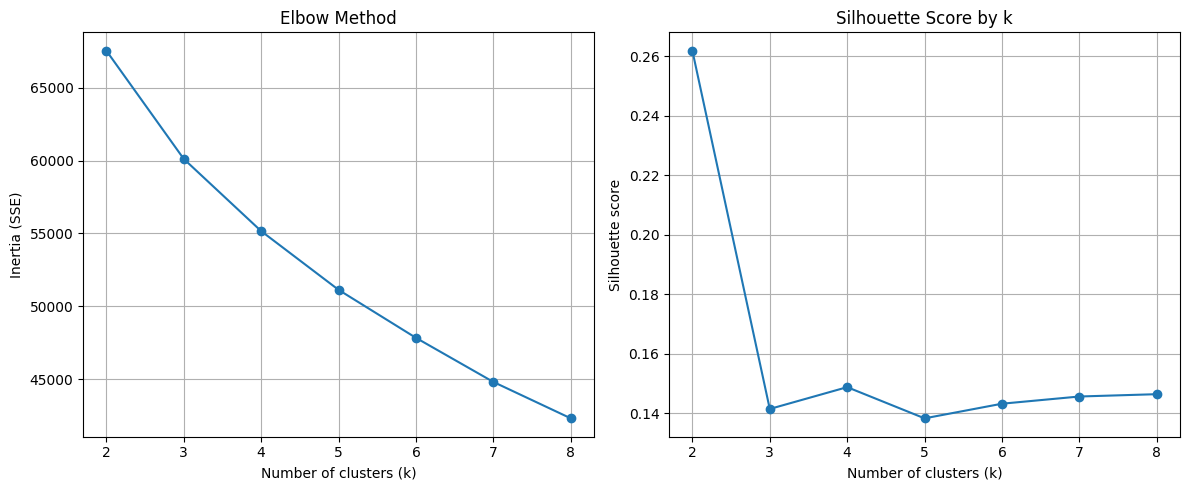

[(2, 0.26181052821741724),
 (3, 0.14137870752865056),
 (4, 0.14871222759464103),
 (5, 0.13822462379876338),
 (6, 0.14314384430559746),
 (7, 0.14556576561405776),
 (8, 0.1463452162090896)]

In [4]:
# Step 4. Choose number of clusters (k) using elbow and silhouette

inertias = []
sil_scores = []
k_values = range(2, 9)

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=RANDOM_STATE,
        n_init=20
    )
    labels = kmeans.fit_predict(X_seg_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_seg_scaled, labels))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Elbow plot
ax[0].plot(k_values, inertias, marker="o")
ax[0].set_xlabel("Number of clusters (k)")
ax[0].set_ylabel("Inertia (SSE)")
ax[0].set_title("Elbow Method")

# Silhouette plot
ax[1].plot(k_values, sil_scores, marker="o")
ax[1].set_xlabel("Number of clusters (k)")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Silhouette Score by k")

plt.tight_layout()
plt.show()

list(zip(k_values, sil_scores))


In [5]:
# Step 5. Fit final K-Means model and assign cluster labels

N_CLUSTERS = 4  # chosen based on elbow + silhouette

kmeans_final = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    n_init=20
)

# Fit K-Means and get labels
cluster_labels = kmeans_final.fit_predict(X_seg_scaled)

# Add cluster labels to the original dataset
df["cluster"] = cluster_labels

# Display cluster counts
df["cluster"].value_counts().sort_index()


cluster
0    1234
1    4577
2    3174
3    1142
Name: count, dtype: int64

In [14]:
# Step 6. Cluster profiling: behavior + churn rate

# Mean of segmentation features per cluster
cluster_feature_means = df.groupby("cluster")[segmentation_features].mean()

# Churn rate per cluster
cluster_churn_rate = df.groupby("cluster")["Churn_Flag"].mean()

# Combine into a summary table
cluster_summary = pd.concat(
    [
        df["cluster"].value_counts().sort_index().rename("n_customers"),
        cluster_churn_rate.rename("churn_rate"),
        cluster_feature_means
    ],
    axis=1
)

cluster_summary
cluster_summary.to_csv("../data/processed/cluster_summary.csv", index=True)

# === New: Export row-level data for Tableau ===
# === Export row-level data for Tableau ===

df_tableau = df.reset_index().rename(columns={"index": "customer_id"})

cols_for_tableau = [
    "customer_id",
    "cluster",
    "Churn_Flag",

    # demographic & relationship
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",

    # credit/financial features
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Avg_Open_To_Buy",

    # transaction behavior
    "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt",
    "Total_Ct_Chng_Q4_Q1",
    "Total_Trans_Ct"
]

# 若 dataframe 有這些欄位才保留
cols_for_tableau = [c for c in cols_for_tableau if c in df_tableau.columns]

df_tableau = df_tableau[cols_for_tableau]

df_tableau.to_csv("../data/processed/cluster_tableau.csv", index=False)


Cluster 0: High-Value but Inactive Segment

This segment represents high-potential customers with the highest credit limits and above-average revolving balances. Despite their financial value, they exhibit declining engagement—shown by higher inactivity counts and reduced transaction frequency compared to other active clusters. Their churn rate (16%) is substantially higher than loyal high-activity customers, indicating an early-stage disengagement pattern.

SHAP analysis confirms that lower Total_Trans_Ct, lower Total_Trans_Amt, and higher Months_Inactive_12_mon are strong churn predictors in our model. Cluster 0 aligns with these patterns, making them a critical priority for proactive retention intervention.

Cluster 0 shows high-value attributes (limit, balance), but reduced activity (inactivity months ↑), making them exactly your “high-value but inactive customers.”

In [15]:
# Simulated ROI scenarios for a reactivation campaign on Cluster 0

import pandas as pd

# Assumptions
segment_size = 1234          # number of customers in Cluster 0
baseline_churn = 0.16        # current churn rate for Cluster 0
value_per_customer = 300.0   # assumed annual value per retained customer (USD)

# 我們這裡把 cost 當成 cashback/offer 大小，讓它可以對應到 dashboard 的 slider
# 不同 cashback / offer 水準（你可以自己調整）
cashback_levels = [0, 5, 10, 15, 20, 25, 30]   # 單位：USD per customer

# 假設：每多 5 美金 cashback，churn 會多下降 1%（你可以改成自己的模型）
# 例如：5 元 → 1% lift，10 元 → 2% lift ...
def lift_from_cashback(cb):
    return 0.01 * (cb / 5.0)   # 非線性也可以自己改

rows = []
for cb in cashback_levels:
    retention_lift = lift_from_cashback(cb)       # 絕對 churn 降幅（例如 0.02 = -2%）
    churn_after = max(baseline_churn - retention_lift, 0)

    # Incremental customers retained due to campaign
    incremental_customers = segment_size * retention_lift

    # Incremental gross profit from retention
    incremental_revenue = incremental_customers * value_per_customer

    # Campaign cost = 每人給多少 cashback * 目標客戶數
    campaign_cost = segment_size * cb

    # Net profit and ROI
    net_profit = incremental_revenue - campaign_cost
    roi = net_profit / campaign_cost if campaign_cost > 0 else None

    rows.append({
        "cashback": cb,
        "retention_lift": retention_lift,
        "churn_before": baseline_churn,
        "churn_after": churn_after,
        "incremental_customers": incremental_customers,
        "incremental_revenue": incremental_revenue,
        "campaign_cost": campaign_cost,
        "net_profit": net_profit,
        "roi": roi
    })

roi_df = pd.DataFrame(rows)
roi_df

# 輸出成給 Power BI 用的 roi_simulation.csv
roi_df.to_csv("../data/processed/roi_simulation.csv", index=False)


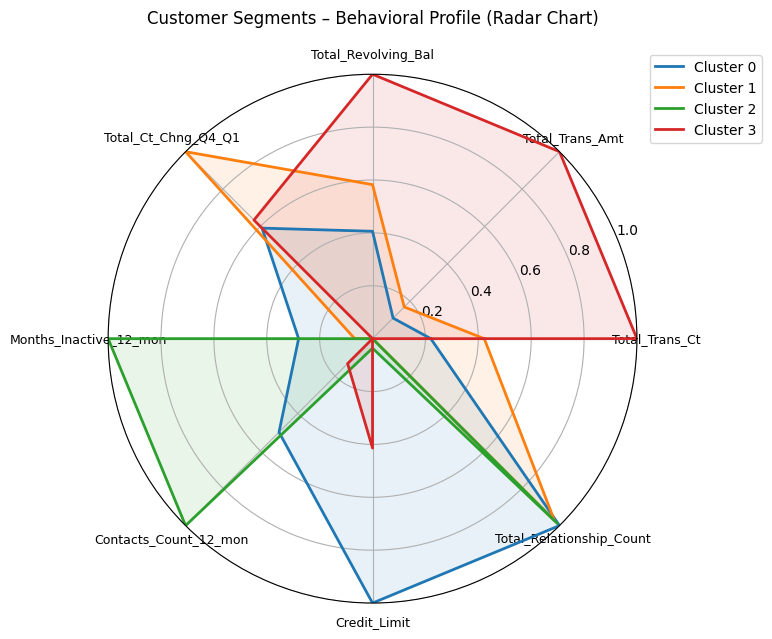

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 讀取你之前輸出的 cluster_summary
summary_path = "../data/processed/cluster_summary.csv"
summary = pd.read_csv(summary_path)

# 如果第一欄是 cluster 編號，就當成一個column用
# （你之前 to_csv(index=True)，這樣會有 'cluster' 這欄）
if "cluster" in summary.columns:
    summary = summary.sort_values("cluster")
else:
    # 萬一 cluster 在 index（比較少見），可以這樣處理
    summary = summary.reset_index().rename(columns={"index": "cluster"})

# 想放在雷達圖上的行為特徵
features = [
    "Total_Trans_Ct",
    "Total_Trans_Amt",
    "Total_Revolving_Bal",
    "Total_Ct_Chng_Q4_Q1",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Relationship_Count",
]

# 只留下存在的欄位（避免 typo）
features = [f for f in features if f in summary.columns]

# 取出這些欄位做 min-max scaling 到 0–1
data = summary[features].copy()
data_norm = (data - data.min()) / (data.max() - data.min())

# 雷達圖的角度設定
labels = features
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 首尾相連

# 開始畫圖
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for _, row in summary.iterrows():
    cluster_id = int(row["cluster"])
    values = data_norm.loc[row.name].tolist()
    values += values[:1]  # 收尾相連

    ax.plot(angles, values, linewidth=2, label=f"Cluster {cluster_id}")
    ax.fill(angles, values, alpha=0.1)

# 設定角度刻度
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=9)

# 從 0～1
ax.set_ylim(0, 1)

plt.title("Customer Segments – Behavioral Profile (Radar Chart)", y=1.08)
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.05))
plt.tight_layout()
plt.show()


                   ┌────────────────────────┐
                   │   Select Target Group   │
                   │  Cluster 0 (n = 1234)   │
                   └─────────────┬──────────┘
                                 │
                                 ▼
                  ┌───────────────────────────┐
                  │   Random Split (50/50)     │
                  │  Treatment vs. Control     │
                  └─────────────┬─────────────┘
                                 │
                 ┌───────────────┴────────────────┐
                 │                                │
                 ▼                                ▼
     ┌──────────────────────┐        ┌────────────────────────┐
     │   Treatment Group     │        │     Control Group      │
     │ Receives offer:       │        │ No intervention        │
     │ - $10 cashback        │        │ Baseline behavior      │
     │   after 3 transactions│        │                        │
     │   within 30 days      │        │                        │
     └───────────┬───────────┘        └──────────┬────────────┘
                 │                                │
                 ▼                                ▼
    ┌─────────────────────────┐     ┌────────────────────────────┐
    │   Measure KPIs (60 days)│     │   Measure KPIs (60 days)    │
    │  - Churn rate           │     │  - Churn rate               │
    │  - Transaction count    │     │  - Transaction count        │
    │  - Revenue per user     │     │  - Revenue per user         │
    └───────────┬─────────────┘     └──────────────┬────────────┘
                 │                                 │
                 ▼                                 ▼
           ┌──────────────────────────────────────────────┐
           │   Compare Treatment vs. Control Results       │
           │ - Churn reduction                             │
           │ - Incremental revenue                         │
           │ - Campaign cost                               │
           │ - Net profit & ROI                            │
           └──────────────────────────────────────────────┘
